# Attempt to fit Rabi flop and/ or extract the mean phonon number

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
from glob import glob1
import os

from rabi_flops_fit import fit_population_with_phonon, fit_rabi_flop,cut_off_rabi_flops,fit_rabi_flop_damped

No module named 'Detect_peaks'


In [3]:
import matplotlib
textsize = 15

matplotlib.rcParams.update({'font.size': textsize})
matplotlib.rcParams['lines.linewidth'] = 3
matplotlib.rcParams['font.family']='arial'
params = {'legend.edgecolor': '0',
          'font.family' : 'arial',
          'lines.markersize' : 10,
          'legend.borderaxespad': 1.5,
          'legend.fancybox': False,
          'legend.fontsize': textsize*0.8,
          'legend.framealpha': 0.5,
          'legend.labelspacing': 0.3,
          'legend.markerscale': 1.0,
          'figure.figsize': (10*0.75, 0.75*8),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'axes.linewidth': 3,
         'axes.xmargin': 0.03,
         'axes.ymargin': 0.03,
         'xtick.direction': 'in',
         'xtick.labelsize': textsize,
         'xtick.major.pad': 10,
         'xtick.major.size': 10,
         'xtick.major.width': 3,
         'xtick.minor.pad': 10,
         'xtick.minor.size': 5,
         'xtick.minor.visible': True,
         'xtick.minor.width': 2,
         'xtick.top': True,
         'ytick.direction': 'in',
         'ytick.labelsize': textsize,
         'ytick.major.pad': 10,
         'ytick.major.size': 10,
         'ytick.major.width': 3,
         'ytick.minor.pad': 10,
         'ytick.minor.size': 5,
         'ytick.minor.visible': True,
         'ytick.minor.width': 2,
         'ytick.right': True,}
plt.rcParams.update(params)


In [4]:
directory = r'Z:\qfc\measurements\trics_data'
folder = '2022-02-18'
# subfolder = '155829'
subfolder = '160146'
target = 'camera_all.txt'
xdata = 'Camera1_1.txt'

datafilename = os.path.join(directory,folder,subfolder,target)
xfilename = os.path.join(directory,folder,subfolder,xdata)
saved_filedir = r'Z:\qfc\users\Zak\2022-02-17-18_data_analysis'

In [5]:
def load_camera_data(data_file,xdata_file):
    data = np.loadtxt(data_file)
    data_num = data[:,0]
    prev = data_num[-1]
    valid = np.ones(len(data_num),dtype='bool')
    for j in range(len(data_num)-2,0,-1):
        if data_num[j] == prev:
            valid[j] = False
        prev = data_num[j]
    x = np.genfromtxt(xdata_file,usecols=range(2,3),skip_header=1)

    return data[valid][:,1:],x

# Load file and check the dimensions of the arrays

In [6]:
_data,probe_729pulse_length  = load_camera_data(datafilename,xfilename)

# Display raw data

(0.0, 1.03)

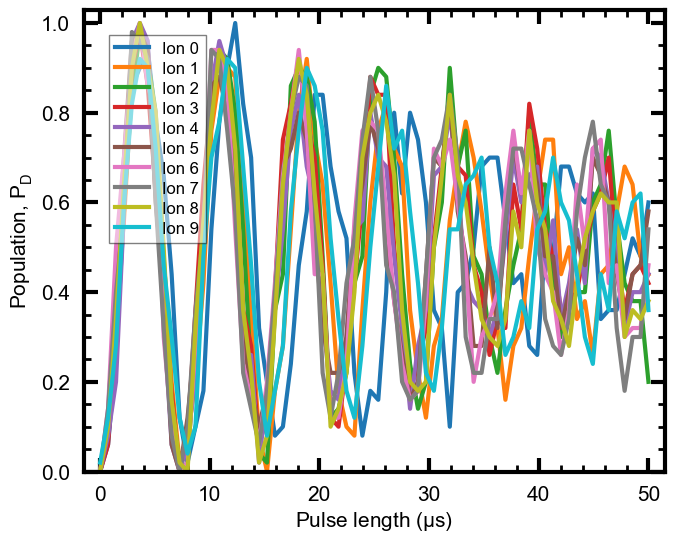

In [7]:
for j in range(_data.shape[1]):
    plt.plot(probe_729pulse_length,_data[:,j],
             label='Ion {0:.0f}'.format(j))
plt.legend()
plt.xlabel(r'Pulse length ($\mathregular{\mu s}$)')
plt.ylabel(r'Population, $\mathregular{P_D}$')
plt.ylim(bottom=0)

[[Model]]
    Model(rabi_flop_damped)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 70
    # variables        = 2
    chi-square         = 0.30935076
    reduced chi-square = 0.00454928
    Akaike info crit   = -375.524232
    Bayesian info crit = -371.027241
[[Variables]]
    rabi_freq:  0.13373529 +/- 2.4245e-04 (0.18%) (init = 0.1379999)
    damp:       5.0257e-04 +/- 2.8522e-05 (5.68%) (init = 0.001)
    const:      0 (fixed)


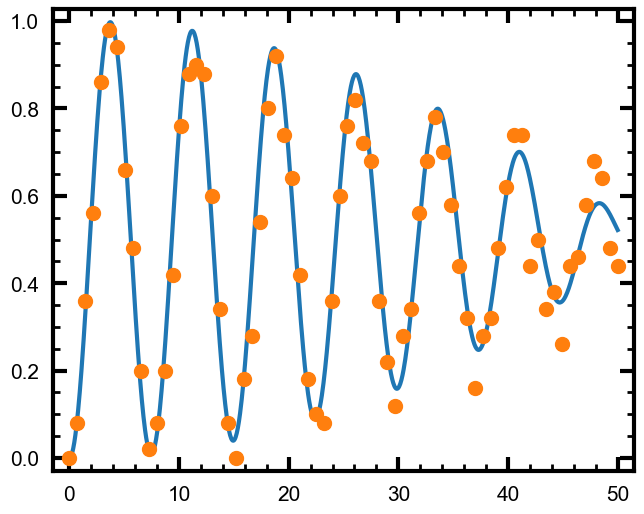

In [28]:

x = probe_729pulse_length
y = _data[:,1]
dummyx = np.linspace(min(x),max(x),1000)

result, mod  = fit_rabi_flop_damped(x,y,const_zero=True,isplot=True, fitreport=True)




# Fit and analyze the data

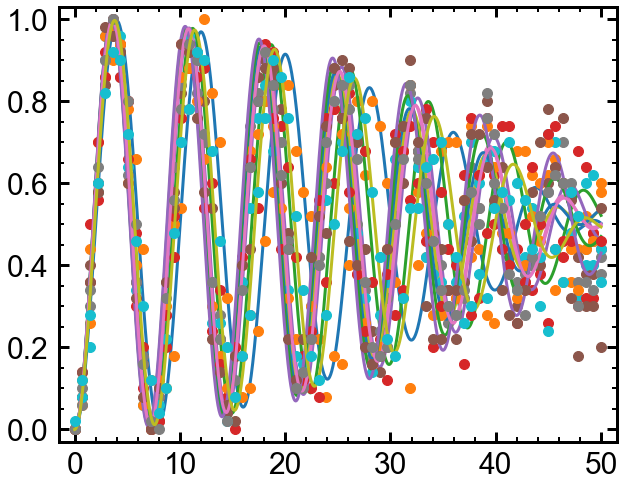

In [33]:
rabi_freq = np.zeros((_data.shape[1],2))
detuning = np.zeros((_data.shape[1],2))
results = []
for j in range(_data.shape[1]):
    # perfect no damping
#     res,mod = fit_rabi_flop(probe_729pulse_length,_data[:,j],isplot=True,fitreport= True)
    
    #  damping and only one mode phonon
#     res,mod = fit_population_with_phonon(probe_729pulse_length,_data[:,j],isplot=True,fitreport= True)
    
    # damping and more general 
    res,mod = fit_rabi_flop_damped(probe_729pulse_length[:],_data[:,j][:],isplot=True,fitreport=not True)
    
    results.append(res.params)
    rabi_freq [j][0] = res.params['rabi_freq'].value
    rabi_freq [j][1] = res.params['rabi_freq'].stderr
    
    try:
        detuning [j][0] = res.params['detuning'].value
        if res.params['detuning'].stderr/res.params['detuning'].value > 100:
            pass
        else:
            detuning [j][1] = res.params['detuning'].stderr
    except Exception as ep:
#         print (ep)
        try:
            detuning [j][0] = res.params['phonon'].value
            detuning [j][1] = res.params['phonon'].stderr
        except:
            detuning [j][0] = res.params['damp'].value
            detuning [j][1] = res.params['damp'].stderr



# Display data

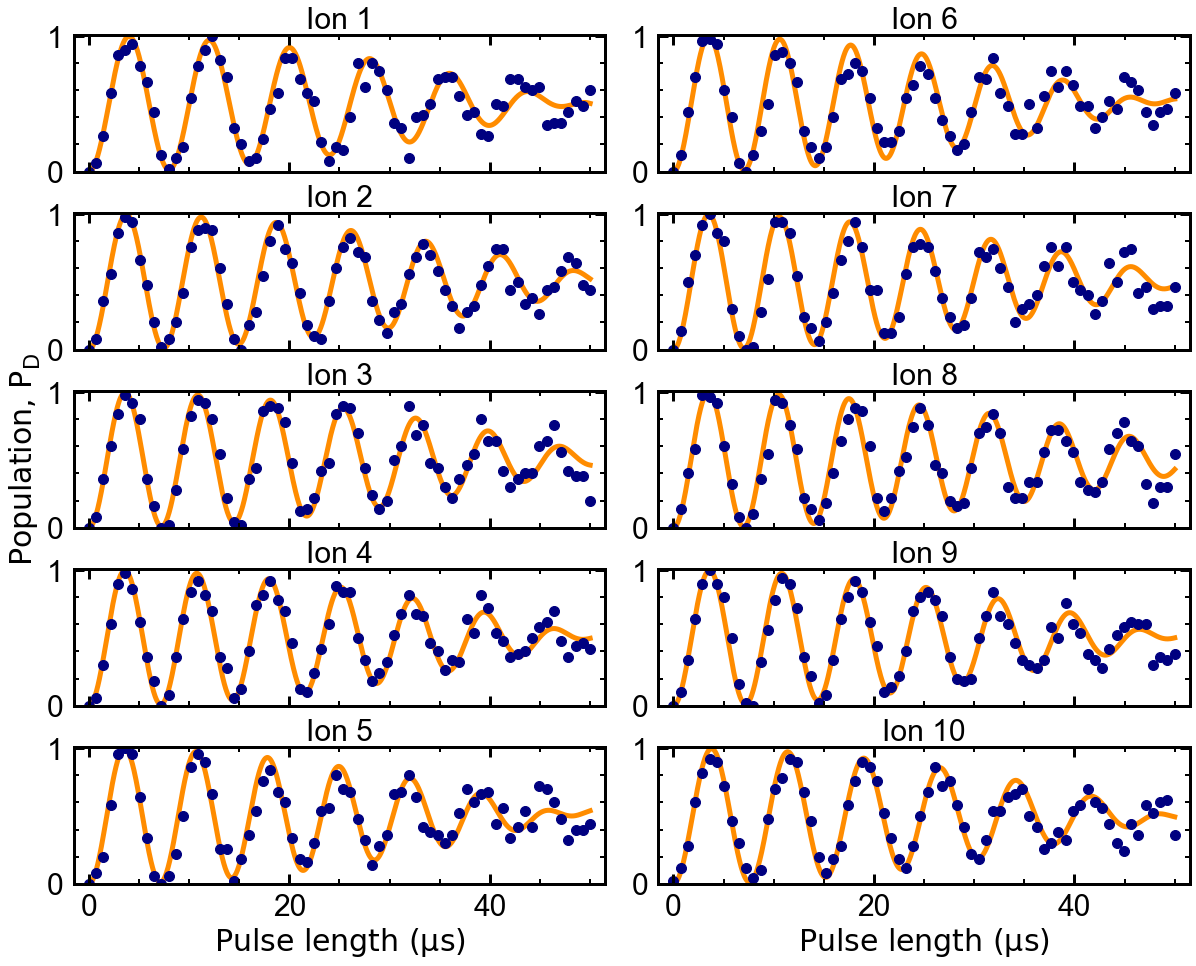

In [34]:
detailed = False
saved = not True
f = plt.figure(figsize=(20,32))
f.subplots_adjust(wspace=0.1,hspace=0.3)
dummyx = np.linspace(min(probe_729pulse_length),max(probe_729pulse_length),1000)

counter = 0

for j in range(_data.shape[1]):
    
    if counter ==0:
        plt.subplot(10,2,j+1)
    elif counter < int(_data.shape[1]/2):
        plt.subplot(10,2,j+1+counter)
    else:
        plt.subplot(10,2,j+2+counter - _data.shape[1])
    
    counter += 1

    plt.plot(probe_729pulse_length,_data[:,j],'o',color='navy',zorder=1)
    try:
        plt.plot(dummyx,Rabi_flop(dummyx,rabi_freq[:,0][j],detuning[:,0][j]),color='darkorange',zorder=0,lw=5)
    except:
        plt.plot(dummyx,mod.eval(results[j],t= dummyx),color='darkorange',zorder=0,lw=5)
        pass
    plt.ylim(0,1.01)

    if detailed:
#         plt.title(r'Ion {0:.0f}: $\left<n\right>={1:.0f}\,({2:.0f})$, $\Omega = {3:.0f}\,$kHz'.
#                   format(j+1,detuning [j][0],detuning [j][1], rabi_freq[j][0]*1e3))
        plt.title(r'Ion {0:.0f}: $A={1:.3f}\,({2:.0f})$, $\Omega = {3:.0f}\,$kHz'.
                  format(j+1,detuning [j][0],1e3*detuning [j][1], rabi_freq[j][0]*1e3))
    else:
        plt.title(r'Ion {0:.0f}'.
              format(j+1,detuning [j][0],detuning [j][1], rabi_freq[j][0]*1e3))

    # too much information
#     plt.title(r'Ion {0:.0f}: $\left<n\right>={1:.0f}\,({2:.0f})$, $\Omega = {3:.0f}\,$kHz'.
#               format(j+1,detuning [j][0],detuning [j][1], rabi_freq[j][0]*1e3))
    if j ==4 or j==9:
        plt.xlabel(r'Pulse length ($\mathregular{\mu s}$)')
    else:
        ax = plt.gca()
        ax.xaxis.set_ticklabels([])
    if j==2:
        plt.ylabel(r'Population, $\mathregular{P_D}$')

if saved:
    if detailed:
        f.savefig(saved_filedir+'\\'+subfolder+'_'+target[:-4]+'_too_much_info2.png',dpi=100,bbox_inches='tight',facecolor='white')
    else:
        f.savefig(saved_filedir+'\\'+subfolder+'_'+target[:-4]+'_summary_fits2.png',dpi=100,bbox_inches='tight',facecolor='white')



# Rabi frequency as a function of spacing between ions

In [35]:
from theoretical_ion_spacings import theoretical_ion_spacing_um
ion_spacing = theoretical_ion_spacing_um(numions=10, endcap_voltages=[263, 275])

# Version 1
## Invalid since it contains more than a sinlge phonon modes. 


[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 10
    # variables        = 3
    chi-square         = 14.5900335
    reduced chi-square = 2.08429050
    Akaike info crit   = 9.77753567
    Bayesian info crit = 10.6852909
[[Variables]]
    amplitude:  17091.1922 +/- 791.411404 (4.63%) (init = 828.6393)
    center:     3.01105516 +/- 0.67049702 (22.27%) (init = 0)
    sigma:      47.8680103 +/- 2.36319550 (4.94%) (init = 15.36477)
    fwhm:       112.720548 +/- 5.56490005 (4.94%) == '2.3548200*sigma'
    height:     142.441675 +/- 0.66363819 (0.47%) == '0.3989423*amplitude/max(2.220446049250313e-16, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  =  0.997
    C(amplitude, center) =  0.426
    C(center, sigma)     =  0.414


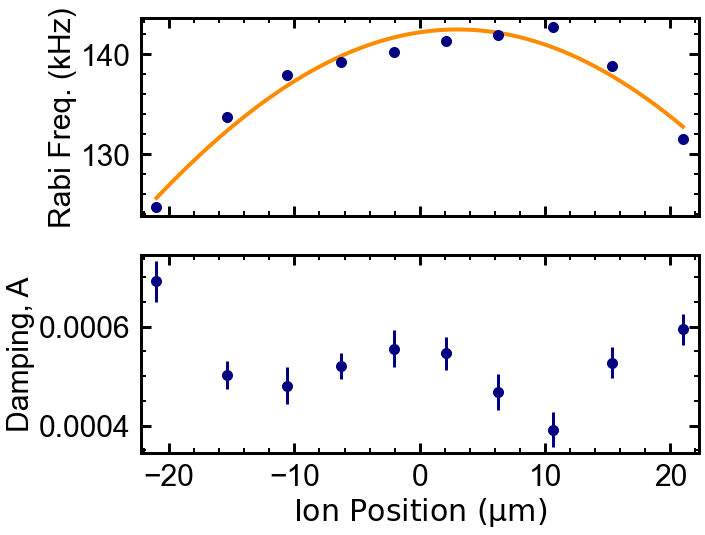

In [36]:
issaved =  True
f = plt.figure()
ax = f.add_subplot(211)
ax.errorbar(ion_spacing,rabi_freq[:,0]*1e3,yerr=rabi_freq[:,1]*1e3,fmt='o',color='navy',zorder=1)

from lmfit.models import GaussianModel, ConstantModel

mod = GaussianModel()

params = mod.guess(rabi_freq[:,0]*1e3,x=ion_spacing) 

res = mod.fit(rabi_freq[:,0]*1e3,params,x=ion_spacing)
xx = np.linspace(min(ion_spacing),max(ion_spacing),1000)
ax.plot(xx,mod.eval(res.params,x=xx),color='darkorange',lw=4,zorder=0)

print (res.fit_report())
ax.set_ylabel('Rabi Freq. (kHz)')
ax.set_xticklabels([])

ax1 = f.add_subplot(212)
ax1.errorbar(ion_spacing,detuning [:,0]*1e0,yerr=detuning [:,1]*1e0,fmt='o',color='navy')
ax1.set_xlabel('Ion Position ($\mathregular{\mu m}$)')
ax1.set_ylabel(r'Damping, A')
# ax1.set_ylim(bottom=0)
if issaved:
    f.savefig(saved_filedir+'\\'+subfolder+'_'+target[:-4]+'_summary_rabi_damping.png',dpi=100,bbox_inches='tight',facecolor='white')

# Version 2
## Display the 1/e decay parameter instead


In [51]:
cutoff = np.array([cut_off_rabi_flops(detuning [:,0][j],rabi_freq[:,0][j]) for j in range(len(rabi_freq))])

# cut_off_rabi_flops()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 10
    # variables        = 3
    chi-square         = 6.96820615
    reduced chi-square = 0.99545802
    Akaike info crit   = 2.38772732
    Bayesian info crit = 3.29548260
[[Variables]]
    amplitude:  18089.6755 +/- 576.527964 (3.19%) (init = 658.5981)
    center:     3.03668903 +/- 0.46132058 (15.19%) (init = 2.194967)
    sigma:      48.7177786 +/- 1.65190025 (3.39%) (init = 12.98827)
    fwhm:       114.721599 +/- 3.88992775 (3.39%) == '2.3548200*sigma'
    height:     148.133535 +/- 0.45826625 (0.31%) == '0.3989423*amplitude/max(2.220446049250313e-16, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  =  0.997
    C(amplitude, center) =  0.430
    C(center, sigma)     =  0.418


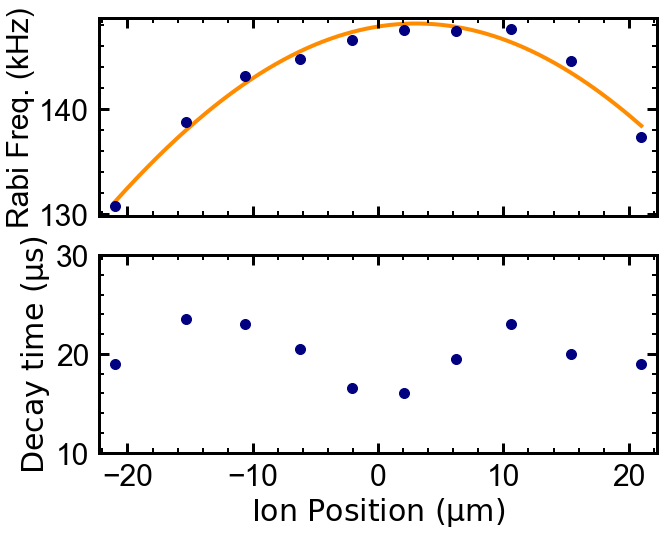

In [56]:
f = plt.figure()
ax = f.add_subplot(211)
ax.errorbar(ion_spacing,rabi_freq[:,0]*1e3,yerr=rabi_freq[:,1]*1e3,fmt='o',color='navy',zorder=1)

from lmfit.models import GaussianModel, ConstantModel

mod = GaussianModel()

params = mod.guess(rabi_freq[:,0]*1e3,x=ion_spacing) 

res = mod.fit(rabi_freq[:,0]*1e3,params,x=ion_spacing)
xx = np.linspace(min(ion_spacing),max(ion_spacing),1000)
ax.plot(xx,mod.eval(res.params,x=xx),color='darkorange',lw=4,zorder=0)

print (res.fit_report())
ax.set_ylabel('Rabi Freq. (kHz)')
ax.set_xticklabels([])

ax1 = f.add_subplot(212)
ax1.errorbar(ion_spacing,cutoff,fmt='o',color='navy')
# ax1.errorbar(ion_spacing,detuning [:,0]*1e0,yerr=detuning [:,1]*1e0,fmt='o',color='navy')
ax1.set_xlabel('Ion Position ($\mathregular{\mu m}$)')
ax1.set_ylabel('Decay time ($\mathregular{\mu s}$)')
# ax1.set_ylim(bottom=0,top=150)
ax1.set_ylim(bottom=10,top=30)
# f.savefig(saved_filedir+'\\'+subfolder+'_'+target[:-4]+'_summary_rabi_decay_time.png',dpi=100,bbox_inches='tight',facecolor='white')

# Radial Beam only

In [13]:
import pandas as pd
display = {"Rabi frequency (kHz)":rabi_freq[:,0]*1e3,
        "dRabi frequency (kHz)":rabi_freq[:,1]*1e3,
        "Phonon number":detuning [:,0]*1e0,
         "dPhonon number":detuning [:,1]*1e0}
pd.DataFrame(display)

Rabi frequency (kHz)  dRabi frequency (kHz)  Phonon number  dPhonon number
0             89.180866               0.356084       4.357760        1.181047
1             88.828300               0.268334       5.646858        0.929733
2             86.361443               0.188402       9.203978        0.715211
3             85.313985               0.250440      13.254591        1.055270
4             85.138963               0.276997      19.902621        1.366800
5             83.878004               0.298065      20.740527        1.543200
6             83.354698               0.258775      11.453537        1.044110
7             84.894442               0.238162       9.181201        0.898366
8             85.067658               0.248593       6.338596        0.878751
9             86.359562               0.226906       5.318544        0.792171

# Axial + Radial

In [24]:
import pandas as pd
display = {"Rabi frequency (kHz)":rabi_freq[:,0]*1e3,
        "dRabi frequency (kHz)":rabi_freq[:,1]*1e3,
        "Phonon number":detuning [:,0]*1e0,
         "dPhonon number":detuning [:,1]*1e0}
pd.DataFrame(display)

Rabi frequency (kHz)  dRabi frequency (kHz)  Phonon number  dPhonon number
0            130.717290               0.340776      18.464912        1.353197
1            138.763337               0.252983      14.436687        0.885639
2            143.183441               0.338479      14.507761        1.134833
3            144.716390               0.295863      15.678634        1.018019
4            146.576608               0.367911      19.099881        1.396612
5            147.534722               0.350129      19.272462        1.338538
6            147.427563               0.357875      15.776196        1.237549
7            147.619668               0.314498      13.741134        1.018985
8            144.565248               0.310487      15.926827        1.077712
9            137.335179               0.297134      17.653149        1.143646

In [315]:
import pandas as pd
display = {"Rabi frequency (kHz)":rabi_freq[:,0]*1e3,
        "dRabi frequency (kHz)":rabi_freq[:,1]*1e3,
        "Detuning (kHz)":detuning [:,0]*1e3,
         "dDetuning (kHz)":detuning [:,1]*1e3}
pd.DataFrame(display)

Rabi frequency (kHz)  dRabi frequency (kHz)  Detuning (kHz)  \
0             87.865843               0.110781    1.000000e-13   
1             87.179132               0.106321    1.000000e-13   
2             83.910086               0.132853    1.000000e-13   
3             81.970101               0.193027    1.000000e-13   
4             80.788454               0.255158    1.000000e-13   
5             79.552473               0.247397    1.000000e-13   
6             80.419253               0.162446    1.000000e-13   
7             82.426231               0.141665    1.000000e-13   
8             83.280216               0.115165    1.000000e-13   
9             84.834051               0.093965    1.000000e-13   

   dDetuning (kHz)  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
5              0.0  
6              0.0  
7              0.0  
8              0.0  
9              0.0